In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
from oe_acute import MNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob

import sys
from oe_acute import pyMNE

In [2]:
os.nice(1)

1

### Load dsets

In [3]:
stim_spec = np.load('/mnt/cube/srrudrar/temporal_model/stim_resp_32x32_128/lag_neg12/enc_train_128_lag_neg4.npy')   ###change
stim_resp = np.load('/mnt/cube/srrudrar/temporal_model/stim_resp_32x32_128/lag_neg12/resp_train_128_lag_neg4.npy')  ###change

In [4]:
np.shape(stim_spec), np.shape(stim_resp)

((49245, 128), (49245, 214, 32))

In [5]:
def prepare_MNE_dset(stim_spec, stim_resp, nsegbins=32, concat=True):
    '''
    Create the dataset for fitting MNE model
    '''
    stim_mne = []
    resp_mne = []
    for s, r in zip(stim_spec, stim_resp):
        #nfreq, ntime = s.shape
        #s_segs = np.stack([s[:, n:(n+nsegbins)] for n in range(ntime - nsegbins)], axis=0)
        s_segs = s
        r_segs = np.sum(r, axis=1)
        stim_mne.append(s_segs)
        resp_mne.append(r_segs)
    if concat:
        return np.vstack(stim_mne), np.vstack(resp_mne)
    else:
        return stim_mne, resp_mne

In [6]:
nsegbins = 32

In [7]:
stim_mne = []
resp_mne = []
stim_mne, resp_mne = prepare_MNE_dset(stim_spec, stim_resp, nsegbins=nsegbins)

In [8]:
np.shape(stim_mne), np.shape(resp_mne)

((49245, 128), (49245, 214))

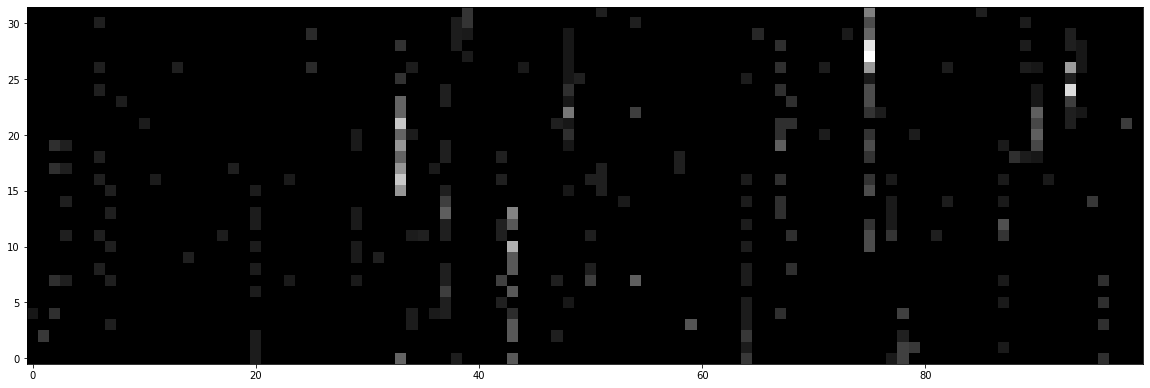

In [9]:
ax = plt.subplots(figsize=(20,8))
plt.imshow(np.transpose(stim_resp[:100, 20, :]), origin='lower', cmap='gray')

### Split into train test sets

In [10]:
len_units = np.shape(resp_mne)[1]

In [11]:
ind = [165, 16, 191, 114, 12, 50, 96, 38, 211, 82, 130, 76, 142, 102, 107, 159, 156,
       66, 67, 206, 110, 93, 122, 125, 187, 68, 80, 81, 205, 147, 186, 63, 170, 51,
       2, 128, 41, 207, 35, 11, 21, 183, 112, 145, 53, 209, 57, 75, 31, 33]
units_to_process_all = np.load('/mnt/cube/srrudrar/temporal_model/units_to_process.npy')
units_to_process = list(units_to_process_all[ind])

In [12]:
exp_path = '/mnt/cube/srrudrar/temporal_model/stim_resp_32x32_128/lag_neg12'                                         ###change

In [13]:
# obtain all preprocessed datas

%matplotlib inline
sdim = 32
n_jackknives = 4

test_output_path = os.path.join(exp_path, 'MNE_test_dset')
os.makedirs(test_output_path, exist_ok=True)
n_eigvec_to_display = 6 # Number of most positive and most negative eigenvectors to display

pfinals = {}
for unit in units_to_process:
    i = units_to_process.index(unit)
    stims_train, resps_train, stims_test, resps_test = MNE.prepare_MNE_train_test_set(stim_mne, resp_mne[:,i][:,np.newaxis], train_pct=0.8, zscore=True, kz_norm_resp=True)
    
    # Save test dataset
    test_dict = {'stims_test':stims_test, 'resps_test':resps_test}
    out_fname = 'unit-{}_MNE.pkl'.format(unit)
    out_f = os.path.join(test_output_path, out_fname)
    with open(out_f, 'wb') as f:
        pickle.dump(test_dict, f)

    # Run MNE
    pfinal = MNE.fit_MNE(stims_train, resps_train, order=2)
    #MNE.plot_MNE(pfinal, unit, figure_output_path)
    pfinals[unit] = pfinal

Iters   tally   ll(test) 
    1       0    0.138002
    2       0    0.136349
    3       0    0.133795
    4       0    0.127337
    5       0    0.125166
    6       0    0.123731
    7       0    0.122457
    8       0    0.121672
    9       0    0.120492
   10       0    0.118597
   11       0    0.117250
   12       0    0.116822
   13       0    0.116383
   14       0    0.115851
   15       0    0.115494
   16       0    0.115015
   17       0    0.114579
   18       0    0.114418
   19       0    0.114019
   20       0    0.113939
   21       0    0.113861
   22       0    0.113837
   23       0    0.113129
   24       0    0.113021
   25       0    0.112625
   26       0    0.111929
   27       0    0.111358
   28       0    0.110956
   29       0    0.110773
   30       0    0.110589
   31       0    0.110518
   32       0    0.110426
   33       0    0.110242
   34       0    0.110233
   35       0    0.110213
   36       0    0.110120
   37       0    0.110034
   38       

   74       0    0.106958
   75       0    0.106892
   76       0    0.106939
   77       1    0.106954
   78       2    0.106863
   79       0    0.106846
   80       0    0.106846
   81       1    0.106837
   82       0    0.106817
   83       0    0.106805
   84       0    0.106784
   85       0    0.106784
   86       0    0.106780
   87       0    0.106775
   88       0    0.106769
   89       0    0.106737
   90       0    0.106744
   91       1    0.106754
   92       2    0.106674
   93       0    0.106652
   94       0    0.106666
   95       1    0.106657
   96       2    0.106607
   97       0    0.106597
   98       0    0.106639
   99       1    0.106720
  100       2    0.106689
  101       3    0.106637
  102       4    0.106584
  103       0    0.106570
  104       0    0.106546
  105       0    0.106547
  106       1    0.106539
  107       0    0.106557
  108       1    0.106574
  109       2    0.106562
  110       3    0.106569
  111       4    0.106570
  112       

    8       0    0.101408
    9       0    0.100513
   10       0    0.100210
   11       0    0.099736
   12       0    0.099318
   13       0    0.099057
   14       0    0.098719
   15       0    0.098486
   16       0    0.098371
   17       0    0.098012
   18       0    0.097394
   19       0    0.097006
   20       0    0.096822
   21       0    0.096471
   22       0    0.096182
   23       0    0.095740
   24       0    0.095404
   25       0    0.095221
   26       0    0.095229
   27       1    0.094966
   28       0    0.094779
   29       0    0.094656
   30       0    0.094646
   31       0    0.094611
   32       0    0.094429
   33       0    0.094409
   34       0    0.094389
   35       0    0.094315
   36       0    0.094274
   37       0    0.094259
   38       0    0.094200
   39       0    0.094138
   40       0    0.094083
   41       0    0.094068
   42       0    0.093991
   43       0    0.093862
   44       0    0.093833
   45       0    0.093630
   46       

   69       0    0.091868
   70       0    0.091803
   71       0    0.091848
   72       1    0.091875
   73       2    0.091859
   74       3    0.091825
   75       4    0.091841
   76       5    0.091842
   77       6    0.091799
   78       0    0.091782
   79       0    0.091969
   80       1    0.092110
   81       2    0.092238
   82       3    0.092437
   83       4    0.092614
   84       5    0.092558
   85       6    0.092502
   86       7    0.092434
   87       8    0.092380
   88       9    0.092366
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.114837
    2       0    0.110213
    3       0    0.108108
    4       0    0.106043
    5       0    0.104864
    6       0    0.103579
    7       0    0.101915
    8       0    0.100403
    9       0    0.099766
   10       0    0.098784
   11       0    0.098091
   12       0    0.097733
   13       0    0.097020
   14       0    0.096694
   15       0    0.096459
   16       0    0.096204
   17       

  163       3    0.089702
  164       4    0.089701
  165       5    0.089718
  166       6    0.089708
  167       7    0.089690
  168       8    0.089696
  169       9    0.089697
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.110300
    2       0    0.106599
    3       0    0.105981
    4       0    0.105285
    5       0    0.103619
    6       0    0.101755
    7       0    0.100819
    8       0    0.100089
    9       0    0.099196
   10       0    0.098226
   11       0    0.097134
   12       0    0.096725
   13       0    0.096498
   14       0    0.096269
   15       0    0.096185
   16       0    0.095784
   17       0    0.095463
   18       0    0.094750
   19       0    0.094348
   20       0    0.094017
   21       0    0.093901
   22       0    0.093707
   23       0    0.093320
   24       0    0.093062
   25       0    0.092987
   26       0    0.092872
   27       0    0.092880
   28       1    0.092834
   29       0    0.092678
   30       

   77       0    0.089618
   78       0    0.089620
   79       1    0.089612
   80       0    0.089607
   81       0    0.089593
   82       0    0.089561
   83       0    0.089550
   84       0    0.089553
   85       1    0.089551
   86       2    0.089543
   87       0    0.089536
   88       0    0.089537
   89       1    0.089533
   90       0    0.089519
   91       0    0.089521
   92       1    0.089503
   93       0    0.089462
   94       0    0.089397
   95       0    0.089449
   96       1    0.089506
   97       2    0.089399
   98       3    0.089371
   99       0    0.089353
  100       0    0.089350
  101       0    0.089338
  102       0    0.089320
  103       0    0.089302
  104       0    0.089310
  105       1    0.089311
  106       2    0.089297
  107       0    0.089294
  108       0    0.089288
  109       0    0.089289
  110       1    0.089285
  111       0    0.089293
  112       1    0.089295
  113       2    0.089277
  114       0    0.089268
  115       

   99       7    0.091029
  100       8    0.091015
  101       9    0.091034
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.109426
    2       0    0.105722
    3       0    0.103251
    4       0    0.101991
    5       0    0.101617
    6       0    0.100479
    7       0    0.100132
    8       0    0.099803
    9       0    0.099455
   10       0    0.098491
   11       0    0.097154
   12       0    0.096682
   13       0    0.096595
   14       0    0.096298
   15       0    0.096145
   16       0    0.095976
   17       0    0.095616
   18       0    0.095235
   19       0    0.095088
   20       0    0.094967
   21       0    0.094911
   22       0    0.094864
   23       0    0.094842
   24       0    0.094747
   25       0    0.094574
   26       0    0.094418
   27       0    0.094290
   28       0    0.094148
   29       0    0.094132
   30       0    0.094096
   31       0    0.094008
   32       0    0.093965
   33       0    0.093885
   34       

   23       0    0.154749
   24       0    0.154653
   25       0    0.154561
   26       0    0.154408
   27       0    0.154183
   28       0    0.154058
   29       0    0.154042
   30       0    0.153869
   31       0    0.153667
   32       0    0.153458
   33       0    0.153098
   34       0    0.152945
   35       0    0.152749
   36       0    0.152632
   37       0    0.152538
   38       0    0.152410
   39       0    0.152204
   40       0    0.152102
   41       0    0.151999
   42       0    0.151985
   43       0    0.151985
   44       0    0.151978
   45       0    0.151933
   46       0    0.151896
   47       0    0.151764
   48       0    0.151722
   49       0    0.151454
   50       0    0.151138
   51       0    0.151063
   52       0    0.150981
   53       0    0.150883
   54       0    0.150851
   55       0    0.150816
   56       0    0.150807
   57       0    0.150773
   58       0    0.150688
   59       0    0.150618
   60       0    0.150534
   61       

   42       0    0.149036
   43       0    0.148891
   44       0    0.148700
   45       0    0.148617
   46       0    0.148517
   47       0    0.148464
   48       0    0.148394
   49       0    0.148391
   50       0    0.148339
   51       0    0.148285
   52       0    0.148288
   53       1    0.148278
   54       0    0.148245
   55       0    0.148223
   56       0    0.148216
   57       0    0.148204
   58       0    0.148161
   59       0    0.148143
   60       0    0.148052
   61       0    0.147959
   62       0    0.147843
   63       0    0.147794
   64       0    0.147704
   65       0    0.147622
   66       0    0.147608
   67       0    0.147585
   68       0    0.147570
   69       0    0.147560
   70       0    0.147571
   71       1    0.147568
   72       2    0.147500
   73       0    0.147522
   74       1    0.147505
   75       2    0.147419
   76       0    0.147440
   77       1    0.147438
   78       2    0.147424
   79       3    0.147352
   80       

   74       2    0.068070
   75       0    0.068053
   76       0    0.068020
   77       0    0.067959
   78       0    0.067953
   79       0    0.067966
   80       1    0.067957
   81       2    0.067955
   82       3    0.067929
   83       0    0.067903
   84       0    0.067886
   85       0    0.067895
   86       1    0.067834
   87       0    0.067842
   88       1    0.068032
   89       2    0.067988
   90       3    0.067600
   91       0    0.067527
   92       0    0.067521
   93       0    0.067582
   94       1    0.067776
   95       2    0.067821
   96       3    0.067749
   97       4    0.067699
   98       5    0.067700
   99       6    0.067650
  100       7    0.067640
  101       8    0.067658
  102       9    0.067642
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.088194
    2       0    0.085238
    3       0    0.083297
    4       0    0.081606
    5       0    0.079613
    6       0    0.079219
    7       0    0.078579
    8       

  101       0    0.067730
  102       1    0.067726
  103       2    0.067734
  104       3    0.067732
  105       4    0.067722
  106       0    0.067709
  107       0    0.067737
  108       1    0.067735
  109       2    0.067723
  110       3    0.067765
  111       4    0.067821
  112       5    0.067780
  113       6    0.067800
  114       7    0.067779
  115       8    0.067760
  116       9    0.067753
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.085536
    2       0    0.082455
    3       0    0.080547
    4       0    0.079367
    5       0    0.078670
    6       0    0.077280
    7       0    0.076582
    8       0    0.075796
    9       0    0.075060
   10       0    0.074246
   11       0    0.074003
   12       0    0.073828
   13       0    0.073312
   14       0    0.073038
   15       0    0.072869
   16       0    0.072796
   17       0    0.072603
   18       0    0.072503
   19       0    0.072200
   20       0    0.071726
   21       

  101       2    0.066238
  102       3    0.066240
  103       4    0.066222
  104       0    0.066221
  105       0    0.066235
  106       1    0.066244
  107       2    0.066218
  108       0    0.066215
  109       0    0.066263
  110       1    0.066314
  111       2    0.066261
  112       3    0.066237
  113       4    0.066261
  114       5    0.066274
  115       6    0.066269
  116       7    0.066251
  117       8    0.066264
  118       9    0.066277
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.129503
    2       0    0.125304
    3       0    0.122371
    4       0    0.118853
    5       0    0.117606
    6       0    0.116142
    7       0    0.113997
    8       0    0.112080
    9       0    0.111060
   10       0    0.109494
   11       0    0.108373
   12       0    0.108072
   13       0    0.107368
   14       0    0.107004
   15       0    0.106712
   16       0    0.106266
   17       0    0.105829
   18       0    0.105452
   19       

  127       0    0.099789
  128       1    0.099814
  129       2    0.099780
  130       3    0.099766
  131       4    0.099794
  132       5    0.099798
  133       6    0.099782
  134       7    0.099780
  135       8    0.099772
  136       9    0.099766
  137       0    0.099786
  138       1    0.099792
  139       2    0.099766
  140       3    0.099756
  141       0    0.099768
  142       1    0.099778
  143       2    0.099767
  144       3    0.099759
  145       4    0.099752
  146       0    0.099767
  147       1    0.099860
  148       2    0.099898
  149       3    0.099885
  150       4    0.099963
  151       5    0.099975
  152       6    0.099949
  153       7    0.099912
  154       8    0.099943
  155       9    0.099997
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.130525
    2       0    0.125427
    3       0    0.123522
    4       0    0.120077
    5       0    0.118378
    6       0    0.117454
    7       0    0.116012
    8       

  135       5    0.100291
  136       0    0.100278
  137       0    0.100268
  138       0    0.100288
  139       1    0.100330
  140       2    0.100354
  141       3    0.100364
  142       4    0.100308
  143       5    0.100281
  144       6    0.100273
  145       7    0.100251
  146       0    0.100260
  147       1    0.100339
  148       2    0.100313
  149       3    0.100237
  150       0    0.100222
  151       0    0.100183
  152       0    0.100177
  153       0    0.100186
  154       1    0.100197
  155       2    0.100205
  156       3    0.100180
  157       4    0.100170
  158       0    0.100166
  159       0    0.100173
  160       1    0.100185
  161       2    0.100193
  162       3    0.100197
  163       4    0.100207
  164       5    0.100200
  165       6    0.100206
  166       7    0.100245
  167       8    0.100332
  168       9    0.100465
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.094556
    2       0    0.091138
    3       

   36       0    0.079022
   37       0    0.078902
   38       0    0.078891
   39       0    0.078875
   40       0    0.078837
   41       0    0.078819
   42       0    0.078788
   43       0    0.078778
   44       0    0.078775
   45       0    0.078738
   46       0    0.078725
   47       0    0.078648
   48       0    0.078517
   49       0    0.078450
   50       0    0.078446
   51       0    0.078391
   52       0    0.078263
   53       0    0.078237
   54       0    0.078181
   55       0    0.078179
   56       0    0.078173
   57       0    0.078126
   58       0    0.078120
   59       0    0.078095
   60       0    0.078085
   61       0    0.078072
   62       0    0.078042
   63       0    0.078048
   64       1    0.078017
   65       0    0.078012
   66       0    0.077992
   67       0    0.078008
   68       1    0.078020
   69       2    0.078007
   70       3    0.077989
   71       0    0.077979
   72       0    0.077966
   73       0    0.077976
   74       

   53       0    0.115900
   54       0    0.115932
   55       1    0.115946
   56       2    0.115862
   57       0    0.115847
   58       0    0.115865
   59       1    0.115858
   60       2    0.115859
   61       3    0.115893
   62       4    0.115937
   63       5    0.115955
   64       6    0.115973
   65       7    0.116105
   66       8    0.116248
   67       9    0.116217
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.132777
    2       0    0.128432
    3       0    0.126927
    4       0    0.125063
    5       0    0.124058
    6       0    0.123642
    7       0    0.122554
    8       0    0.122257
    9       0    0.121766
   10       0    0.121492
   11       0    0.121143
   12       0    0.120688
   13       0    0.120449
   14       0    0.120240
   15       0    0.119512
   16       0    0.117895
   17       0    0.117277
   18       0    0.116949
   19       0    0.116831
   20       0    0.116631
   21       0    0.116557
   22       

   69       0    0.215971
   70       0    0.215983
   71       1    0.215963
   72       0    0.215838
   73       0    0.215847
   74       1    0.215910
   75       2    0.215789
   76       0    0.215611
   77       0    0.215580
   78       0    0.215533
   79       0    0.215529
   80       0    0.215513
   81       0    0.215487
   82       0    0.215500
   83       1    0.215484
   84       0    0.215425
   85       0    0.215427
   86       1    0.215405
   87       0    0.215369
   88       0    0.215378
   89       1    0.215379
   90       2    0.215364
   91       0    0.215365
   92       1    0.215270
   93       0    0.215261
   94       0    0.215217
   95       0    0.215148
   96       0    0.215134
   97       0    0.215154
   98       1    0.215150
   99       2    0.215104
  100       0    0.215095
  101       0    0.215065
  102       0    0.215069
  103       1    0.215081
  104       2    0.215003
  105       0    0.214995
  106       0    0.215008
  107       

   28       0    0.219277
   29       0    0.219290
   30       1    0.219013
   31       0    0.218872
   32       0    0.218550
   33       0    0.218341
   34       0    0.218092
   35       0    0.218080
   36       0    0.217793
   37       0    0.217381
   38       0    0.217219
   39       0    0.217226
   40       1    0.217031
   41       0    0.216911
   42       0    0.216829
   43       0    0.216792
   44       0    0.216666
   45       0    0.216517
   46       0    0.216521
   47       1    0.216473
   48       0    0.216436
   49       0    0.216439
   50       1    0.216332
   51       0    0.216158
   52       0    0.216100
   53       0    0.215990
   54       0    0.216004
   55       1    0.215845
   56       0    0.215529
   57       0    0.215326
   58       0    0.215279
   59       0    0.215194
   60       0    0.215145
   61       0    0.215142
   62       0    0.215083
   63       0    0.215057
   64       0    0.215073
   65       1    0.214984
   66       

   45       0    0.080753
   46       0    0.080746
   47       0    0.080716
   48       0    0.080728
   49       1    0.080725
   50       2    0.080665
   51       0    0.080647
   52       0    0.080519
   53       0    0.080536
   54       1    0.080467
   55       0    0.080309
   56       0    0.080323
   57       1    0.080221
   58       0    0.080184
   59       0    0.080207
   60       1    0.080217
   61       2    0.080203
   62       3    0.080224
   63       4    0.080220
   64       5    0.080209
   65       6    0.080266
   66       7    0.080243
   67       8    0.080187
   68       9    0.080139
   69       0    0.080146
   70       1    0.080143
   71       2    0.080114
   72       0    0.080126
   73       1    0.080098
   74       0    0.080103
   75       1    0.080061
   76       0    0.080103
   77       1    0.080109
   78       2    0.080121
   79       3    0.080077
   80       4    0.080092
   81       5    0.080049
   82       0    0.080017
   83       

   10       0    0.094033
   11       0    0.093035
   12       0    0.092614
   13       0    0.092472
   14       0    0.092506
   15       1    0.091929
   16       0    0.091625
   17       0    0.091796
   18       1    0.091535
   19       0    0.090883
   20       0    0.090728
   21       0    0.090900
   22       1    0.090868
   23       2    0.090553
   24       0    0.090434
   25       0    0.090520
   26       1    0.090186
   27       0    0.090285
   28       1    0.090249
   29       2    0.089790
   30       0    0.089518
   31       0    0.089130
   32       0    0.089196
   33       1    0.089173
   34       2    0.088816
   35       0    0.088823
   36       1    0.088929
   37       2    0.088862
   38       3    0.088765
   39       0    0.088806
   40       1    0.088750
   41       0    0.088677
   42       0    0.088688
   43       1    0.088384
   44       0    0.088375
   45       0    0.088332
   46       0    0.087980
   47       0    0.087931
   48       

   14       0    0.036713
   15       0    0.036541
   16       0    0.036325
   17       0    0.036112
   18       0    0.036017
   19       0    0.035927
   20       0    0.035751
   21       0    0.035657
   22       0    0.035570
   23       0    0.035429
   24       0    0.035402
   25       0    0.035351
   26       0    0.035299
   27       0    0.035269
   28       0    0.035280
   29       1    0.035221
   30       0    0.035198
   31       0    0.035166
   32       0    0.035081
   33       0    0.035086
   34       1    0.035109
   35       2    0.035025
   36       0    0.035010
   37       0    0.034973
   38       0    0.034953
   39       0    0.034957
   40       1    0.034952
   41       0    0.034927
   42       0    0.034911
   43       0    0.034909
   44       0    0.034904
   45       0    0.034881
   46       0    0.034871
   47       0    0.034879
   48       1    0.034859
   49       0    0.034811
   50       0    0.034746
   51       0    0.034747
   52       

  137       7    0.125698
  138       8    0.125841
  139       9    0.125947
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.136039
    2       0    0.133936
    3       0    0.133478
    4       0    0.132474
    5       0    0.131948
    6       0    0.131629
    7       0    0.131501
    8       0    0.131037
    9       0    0.130447
   10       0    0.130170
   11       0    0.129723
   12       0    0.129536
   13       0    0.129321
   14       0    0.129191
   15       0    0.129086
   16       0    0.128937
   17       0    0.128895
   18       0    0.128764
   19       0    0.128525
   20       0    0.128164
   21       0    0.127986
   22       0    0.127732
   23       0    0.127525
   24       0    0.127416
   25       0    0.127378
   26       0    0.127337
   27       0    0.127311
   28       0    0.127216
   29       0    0.127104
   30       0    0.127000
   31       0    0.126971
   32       0    0.126936
   33       0    0.126926
   34       

   51       0    0.126433
   52       0    0.126403
   53       0    0.126403
   54       1    0.126428
   55       2    0.126411
   56       3    0.126397
   57       0    0.126382
   58       0    0.126349
   59       0    0.126349
   60       0    0.126350
   61       1    0.126327
   62       0    0.126306
   63       0    0.126312
   64       1    0.126304
   65       0    0.126260
   66       0    0.126248
   67       0    0.126243
   68       0    0.126154
   69       0    0.126094
   70       0    0.126062
   71       0    0.126054
   72       0    0.125974
   73       0    0.125966
   74       0    0.125981
   75       1    0.125954
   76       0    0.125901
   77       0    0.125907
   78       1    0.125866
   79       0    0.125822
   80       0    0.125776
   81       0    0.125774
   82       0    0.125760
   83       0    0.125725
   84       0    0.125722
   85       0    0.125724
   86       1    0.125702
   87       0    0.125702
   88       0    0.125709
   89       

   23       0    0.522130
   24       0    0.521985
   25       0    0.521831
   26       0    0.521785
   27       0    0.521528
   28       0    0.521441
   29       0    0.521353
   30       0    0.521278
   31       0    0.520971
   32       0    0.520768
   33       0    0.520555
   34       0    0.520495
   35       0    0.520333
   36       0    0.520248
   37       0    0.520234
   38       0    0.520141
   39       0    0.520001
   40       0    0.519911
   41       0    0.519853
   42       0    0.519826
   43       0    0.519718
   44       0    0.519697
   45       0    0.519637
   46       0    0.519526
   47       0    0.519525
   48       0    0.519470
   49       0    0.519408
   50       0    0.519371
   51       0    0.519359
   52       0    0.519334
   53       0    0.519301
   54       0    0.519267
   55       0    0.519219
   56       0    0.519202
   57       0    0.519119
   58       0    0.519055
   59       0    0.519043
   60       0    0.519021
   61       

   52       0    0.486946
   53       0    0.486879
   54       0    0.486818
   55       0    0.486779
   56       0    0.486772
   57       0    0.486733
   58       0    0.486699
   59       0    0.486625
   60       0    0.486586
   61       0    0.486571
   62       0    0.486423
   63       0    0.486307
   64       0    0.486225
   65       0    0.486180
   66       0    0.485952
   67       0    0.485826
   68       0    0.485741
   69       0    0.485696
   70       0    0.485610
   71       0    0.485579
   72       0    0.485589
   73       1    0.485605
   74       2    0.485549
   75       0    0.485515
   76       0    0.485486
   77       0    0.485512
   78       1    0.485552
   79       2    0.485528
   80       3    0.485502
   81       4    0.485478
   82       0    0.485494
   83       1    0.485500
   84       2    0.485504
   85       3    0.485479
   86       4    0.485440
   87       0    0.485388
   88       0    0.485467
   89       1    0.485509
   90       

  114       2    0.484190
  115       0    0.484175
  116       0    0.484176
  117       1    0.484174
  118       0    0.484174
  119       0    0.484171
  120       0    0.484159
  121       0    0.484124
  122       0    0.484123
  123       0    0.484134
  124       1    0.484130
  125       2    0.484105
  126       0    0.484100
  127       0    0.484095
  128       0    0.484053
  129       0    0.484039
  130       0    0.484034
  131       0    0.484034
  132       1    0.484032
  133       0    0.484028
  134       0    0.484032
  135       1    0.484045
  136       2    0.484036
  137       3    0.484012
  138       0    0.484014
  139       1    0.484020
  140       2    0.484029
  141       3    0.484020
  142       4    0.484000
  143       0    0.483997
  144       0    0.484010
  145       1    0.483995
  146       0    0.483965
  147       0    0.483959
  148       0    0.483952
  149       0    0.483961
  150       1    0.483932
  151       0    0.483915
  152       

   84       1    0.126785
   85       0    0.126767
   86       0    0.126734
   87       0    0.126722
   88       0    0.126745
   89       1    0.126736
   90       2    0.126767
   91       3    0.126779
   92       4    0.126686
   93       0    0.126557
   94       0    0.126595
   95       1    0.126545
   96       0    0.126497
   97       0    0.126511
   98       1    0.126464
   99       0    0.126522
  100       1    0.126531
  101       2    0.126450
  102       0    0.126436
  103       0    0.126442
  104       1    0.126421
  105       0    0.126419
  106       0    0.126439
  107       1    0.126435
  108       2    0.126410
  109       0    0.126416
  110       1    0.126430
  111       2    0.126412
  112       3    0.126408
  113       0    0.126421
  114       1    0.126414
  115       2    0.126384
  116       0    0.126447
  117       1    0.126533
  118       2    0.126405
  119       3    0.126453
  120       4    0.126498
  121       5    0.126310
  122       

   11       0    0.134796
   12       0    0.134278
   13       0    0.133768
   14       0    0.133227
   15       0    0.132937
   16       0    0.132419
   17       0    0.132027
   18       0    0.131556
   19       0    0.131391
   20       0    0.131221
   21       0    0.130933
   22       0    0.130564
   23       0    0.130537
   24       0    0.130009
   25       0    0.129402
   26       0    0.129377
   27       0    0.129412
   28       1    0.129056
   29       0    0.128714
   30       0    0.128428
   31       0    0.128268
   32       0    0.128090
   33       0    0.128011
   34       0    0.127887
   35       0    0.127752
   36       0    0.127639
   37       0    0.127265
   38       0    0.127022
   39       0    0.126958
   40       0    0.126894
   41       0    0.126733
   42       0    0.126687
   43       0    0.126563
   44       0    0.126455
   45       0    0.126428
   46       0    0.126438
   47       1    0.126365
   48       0    0.126204
   49       

   35       0    0.204496
   36       0    0.204426
   37       0    0.204456
   38       1    0.204138
   39       0    0.204090
   40       0    0.203896
   41       0    0.203844
   42       0    0.203783
   43       0    0.203736
   44       0    0.203597
   45       0    0.203590
   46       0    0.203543
   47       0    0.203512
   48       0    0.203535
   49       1    0.203547
   50       2    0.203509
   51       0    0.203475
   52       0    0.203448
   53       0    0.203456
   54       1    0.203404
   55       0    0.203258
   56       0    0.203176
   57       0    0.203159
   58       0    0.203132
   59       0    0.203114
   60       0    0.202987
   61       0    0.202836
   62       0    0.202812
   63       0    0.202816
   64       1    0.202728
   65       0    0.202621
   66       0    0.202617
   67       0    0.202670
   68       1    0.202620
   69       2    0.202556
   70       0    0.202492
   71       0    0.202466
   72       0    0.202464
   73       

   34       0    0.206504
   35       0    0.206467
   36       0    0.206360
   37       0    0.206203
   38       0    0.206056
   39       0    0.205917
   40       0    0.205785
   41       0    0.205729
   42       0    0.205662
   43       0    0.205624
   44       0    0.205625
   45       1    0.205539
   46       0    0.205425
   47       0    0.205322
   48       0    0.205244
   49       0    0.205191
   50       0    0.205165
   51       0    0.205114
   52       0    0.205087
   53       0    0.205100
   54       1    0.205066
   55       0    0.205011
   56       0    0.204825
   57       0    0.204789
   58       0    0.204724
   59       0    0.204529
   60       0    0.204508
   61       0    0.204470
   62       0    0.204255
   63       0    0.204139
   64       0    0.204118
   65       0    0.204084
   66       0    0.204061
   67       0    0.203983
   68       0    0.203927
   69       0    0.203912
   70       0    0.203899
   71       0    0.203912
   72       

   43       0    0.366094
   44       0    0.366032
   45       0    0.366012
   46       0    0.366006
   47       0    0.365875
   48       0    0.365775
   49       0    0.365734
   50       0    0.365645
   51       0    0.365583
   52       0    0.365577
   53       0    0.365530
   54       0    0.365486
   55       0    0.365448
   56       0    0.365450
   57       1    0.365394
   58       0    0.365332
   59       0    0.365319
   60       0    0.365186
   61       0    0.365121
   62       0    0.365091
   63       0    0.365039
   64       0    0.364974
   65       0    0.364911
   66       0    0.364919
   67       1    0.364898
   68       0    0.364831
   69       0    0.364813
   70       0    0.364779
   71       0    0.364789
   72       1    0.364779
   73       2    0.364735
   74       0    0.364730
   75       0    0.364705
   76       0    0.364701
   77       0    0.364694
   78       0    0.364632
   79       0    0.364620
   80       0    0.364600
   81       

   36       0    0.155126
   37       0    0.154853
   38       0    0.154717
   39       0    0.154737
   40       1    0.154542
   41       0    0.154417
   42       0    0.154271
   43       0    0.154161
   44       0    0.154123
   45       0    0.154028
   46       0    0.153958
   47       0    0.153930
   48       0    0.153894
   49       0    0.153793
   50       0    0.153748
   51       0    0.153712
   52       0    0.153704
   53       0    0.153667
   54       0    0.153648
   55       0    0.153557
   56       0    0.153541
   57       0    0.153523
   58       0    0.153451
   59       0    0.153421
   60       0    0.153333
   61       0    0.153251
   62       0    0.153121
   63       0    0.153043
   64       0    0.152998
   65       0    0.152981
   66       0    0.152901
   67       0    0.152819
   68       0    0.152817
   69       0    0.152814
   70       0    0.152817
   71       1    0.152784
   72       0    0.152786
   73       1    0.152804
   74       

   13       0    0.158993
   14       0    0.158856
   15       0    0.158647
   16       0    0.158487
   17       0    0.158279
   18       0    0.158102
   19       0    0.158069
   20       0    0.157991
   21       0    0.157772
   22       0    0.157629
   23       0    0.157458
   24       0    0.157184
   25       0    0.156652
   26       0    0.156528
   27       0    0.156138
   28       0    0.156015
   29       0    0.155902
   30       0    0.155875
   31       0    0.155818
   32       0    0.155754
   33       0    0.155762
   34       1    0.155686
   35       0    0.155519
   36       0    0.155361
   37       0    0.155295
   38       0    0.155184
   39       0    0.155107
   40       0    0.155086
   41       0    0.155086
   42       0    0.155003
   43       0    0.154873
   44       0    0.154742
   45       0    0.154593
   46       0    0.154381
   47       0    0.154371
   48       0    0.154262
   49       0    0.154097
   50       0    0.153880
   51       

    1       0    0.090329
    2       0    0.088740
    3       0    0.087238
    4       0    0.086078
    5       0    0.085928
    6       0    0.085513
    7       0    0.084793
    8       0    0.084643
    9       0    0.084367
   10       0    0.083967
   11       0    0.083602
   12       0    0.083547
   13       0    0.083489
   14       0    0.082965
   15       0    0.082772
   16       0    0.082621
   17       0    0.082312
   18       0    0.082249
   19       0    0.082125
   20       0    0.082059
   21       0    0.081819
   22       0    0.081588
   23       0    0.081368
   24       0    0.081307
   25       0    0.081260
   26       0    0.081283
   27       1    0.081288
   28       2    0.081196
   29       0    0.081173
   30       0    0.081139
   31       0    0.081048
   32       0    0.081006
   33       0    0.080981
   34       0    0.080893
   35       0    0.080799
   36       0    0.080781
   37       0    0.080680
   38       0    0.080640
   39       

   45       0    0.079884
   46       0    0.079894
   47       1    0.079909
   48       2    0.079893
   49       3    0.079889
   50       4    0.079878
   51       0    0.079889
   52       1    0.079917
   53       2    0.079898
   54       3    0.079859
   55       0    0.079834
   56       0    0.079785
   57       0    0.079774
   58       0    0.079760
   59       0    0.079745
   60       0    0.079727
   61       0    0.079721
   62       0    0.079721
   63       1    0.079721
   64       2    0.079735
   65       3    0.079755
   66       4    0.079757
   67       5    0.079735
   68       6    0.079705
   69       0    0.079702
   70       0    0.079700
   71       0    0.079684
   72       0    0.079669
   73       0    0.079649
   74       0    0.079639
   75       0    0.079638
   76       0    0.079649
   77       1    0.079660
   78       2    0.079652
   79       3    0.079650
   80       4    0.079649
   81       5    0.079644
   82       6    0.079609
   83       

   54       0    0.072863
   55       1    0.072823
   56       0    0.072839
   57       1    0.072818
   58       0    0.072806
   59       0    0.072689
   60       0    0.072755
   61       1    0.072873
   62       2    0.072830
   63       3    0.072356
   64       0    0.072288
   65       0    0.072225
   66       0    0.072267
   67       1    0.072166
   68       0    0.072028
   69       0    0.072011
   70       0    0.071955
   71       0    0.071886
   72       0    0.071897
   73       1    0.071899
   74       2    0.071875
   75       0    0.071887
   76       1    0.071870
   77       0    0.071859
   78       0    0.071890
   79       1    0.071852
   80       0    0.071888
   81       1    0.071881
   82       2    0.071713
   83       0    0.071687
   84       0    0.071639
   85       0    0.071548
   86       0    0.071560
   87       1    0.071544
   88       0    0.071485
   89       0    0.071488
   90       1    0.071514
   91       2    0.071483
   92       

  109       0    0.074533
  110       0    0.074562
  111       1    0.074556
  112       2    0.074635
  113       3    0.074680
  114       4    0.074679
  115       5    0.074625
  116       6    0.074615
  117       7    0.074599
  118       8    0.074574
  119       9    0.074592
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.096687
    2       0    0.093788
    3       0    0.091514
    4       0    0.089885
    5       0    0.087560
    6       0    0.086743
    7       0    0.085788
    8       0    0.084367
    9       0    0.083721
   10       0    0.083202
   11       0    0.082640
   12       0    0.082097
   13       0    0.082022
   14       0    0.081794
   15       0    0.081381
   16       0    0.081233
   17       0    0.080918
   18       0    0.080416
   19       0    0.079799
   20       0    0.079773
   21       0    0.079542
   22       0    0.079183
   23       0    0.079131
   24       0    0.079059
   25       0    0.078887
   26       

   17       0    0.470861
   18       0    0.470224
   19       0    0.469801
   20       0    0.469239
   21       0    0.469142
   22       0    0.469011
   23       0    0.468635
   24       0    0.468451
   25       0    0.468278
   26       0    0.468120
   27       0    0.467861
   28       0    0.467656
   29       0    0.467455
   30       0    0.466901
   31       0    0.466351
   32       0    0.465986
   33       0    0.465795
   34       0    0.465615
   35       0    0.465474
   36       0    0.465365
   37       0    0.465339
   38       0    0.465277
   39       0    0.465169
   40       0    0.465098
   41       0    0.464999
   42       0    0.464950
   43       0    0.464923
   44       0    0.464891
   45       0    0.464859
   46       0    0.464841
   47       0    0.464813
   48       0    0.464787
   49       0    0.464777
   50       0    0.464706
   51       0    0.464563
   52       0    0.464503
   53       0    0.464287
   54       0    0.464062
   55       

   55       0    0.463269
   56       0    0.463257
   57       0    0.463271
   58       1    0.463249
   59       0    0.463049
   60       0    0.462843
   61       0    0.462821
   62       0    0.462797
   63       0    0.462748
   64       0    0.462721
   65       0    0.462670
   66       0    0.462662
   67       0    0.462685
   68       1    0.462684
   69       2    0.462625
   70       0    0.462608
   71       0    0.462605
   72       0    0.462581
   73       0    0.462571
   74       0    0.462589
   75       1    0.462505
   76       0    0.462418
   77       0    0.462371
   78       0    0.462295
   79       0    0.462332
   80       1    0.462364
   81       2    0.462215
   82       0    0.462165
   83       0    0.462101
   84       0    0.461980
   85       0    0.461978
   86       0    0.461990
   87       1    0.461895
   88       0    0.461890
   89       0    0.461877
   90       0    0.461869
   91       0    0.461861
   92       0    0.461880
   93       

  118       6    0.131671
  119       7    0.131664
  120       8    0.131671
  121       9    0.131667
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.154857
    2       0    0.153158
    3       0    0.149685
    4       0    0.147926
    5       0    0.146164
    6       0    0.145122
    7       0    0.144294
    8       0    0.143596
    9       0    0.142689
   10       0    0.142468
   11       0    0.141917
   12       0    0.140835
   13       0    0.139892
   14       0    0.139081
   15       0    0.138807
   16       0    0.138521
   17       0    0.138185
   18       0    0.137941
   19       0    0.137561
   20       0    0.137365
   21       0    0.137255
   22       0    0.136904
   23       0    0.136854
   24       0    0.136781
   25       0    0.136559
   26       0    0.136359
   27       0    0.136246
   28       0    0.136118
   29       0    0.136079
   30       0    0.136046
   31       0    0.135953
   32       0    0.135847
   33       

   40       0    0.031755
   41       0    0.031751
   42       0    0.031667
   43       0    0.031661
   44       0    0.031669
   45       1    0.031696
   46       2    0.031651
   47       0    0.031612
   48       0    0.031635
   49       1    0.031625
   50       2    0.031557
   51       0    0.031572
   52       1    0.031572
   53       2    0.031584
   54       3    0.031576
   55       4    0.031572
   56       5    0.031530
   57       0    0.031519
   58       0    0.031520
   59       1    0.031548
   60       2    0.031589
   61       3    0.031525
   62       4    0.031502
   63       0    0.031513
   64       1    0.031517
   65       2    0.031483
   66       0    0.031489
   67       1    0.031530
   68       2    0.031453
   69       0    0.031437
   70       0    0.031513
   71       1    0.031701
   72       2    0.031562
   73       3    0.031480
   74       4    0.031459
   75       5    0.031581
   76       6    0.031756
   77       7    0.031728
   78       

   62       0    0.030425
   63       0    0.030457
   64       1    0.030439
   65       2    0.030397
   66       0    0.030384
   67       0    0.030385
   68       1    0.030402
   69       2    0.030398
   70       3    0.030374
   71       0    0.030348
   72       0    0.030329
   73       0    0.030347
   74       1    0.030309
   75       0    0.030284
   76       0    0.030313
   77       1    0.030309
   78       2    0.030288
   79       3    0.030278
   80       0    0.030289
   81       1    0.030238
   82       0    0.030187
   83       0    0.030176
   84       0    0.030196
   85       1    0.030213
   86       2    0.030159
   87       0    0.030124
   88       0    0.030121
   89       0    0.030132
   90       1    0.030137
   91       2    0.030120
   92       0    0.030116
   93       0    0.030132
   94       1    0.030143
   95       2    0.030138
   96       3    0.030123
   97       4    0.030145
   98       5    0.030126
   99       6    0.030110
  100       

   31       0    0.214152
   32       0    0.214131
   33       0    0.213940
   34       0    0.213670
   35       0    0.213646
   36       0    0.213538
   37       0    0.213383
   38       0    0.213191
   39       0    0.213119
   40       0    0.212779
   41       0    0.212690
   42       0    0.212754
   43       1    0.212697
   44       2    0.212564
   45       0    0.212503
   46       0    0.212477
   47       0    0.212489
   48       1    0.212399
   49       0    0.212350
   50       0    0.212174
   51       0    0.212060
   52       0    0.212061
   53       1    0.212037
   54       0    0.211963
   55       0    0.211965
   56       1    0.211926
   57       0    0.211886
   58       0    0.211877
   59       0    0.211892
   60       1    0.211882
   61       2    0.211793
   62       0    0.211792
   63       0    0.211802
   64       1    0.211757
   65       0    0.211723
   66       0    0.211733
   67       1    0.211647
   68       0    0.211502
   69       

   18       0    0.044175
   19       0    0.044008
   20       0    0.043904
   21       0    0.043845
   22       0    0.043835
   23       0    0.043749
   24       0    0.043680
   25       0    0.043632
   26       0    0.043330
   27       0    0.043314
   28       0    0.043213
   29       0    0.043114
   30       0    0.043075
   31       0    0.043090
   32       1    0.043053
   33       0    0.043115
   34       1    0.043061
   35       2    0.043135
   36       3    0.043109
   37       4    0.042969
   38       0    0.042945
   39       0    0.042830
   40       0    0.042755
   41       0    0.042762
   42       1    0.042751
   43       0    0.042775
   44       1    0.042701
   45       0    0.042710
   46       1    0.042753
   47       2    0.042738
   48       3    0.042798
   49       4    0.042768
   50       5    0.042638
   51       0    0.042683
   52       1    0.042678
   53       2    0.042509
   54       0    0.042515
   55       1    0.042487
   56       

   19       0    0.239760
   20       0    0.239282
   21       0    0.239022
   22       0    0.238383
   23       0    0.238072
   24       0    0.237918
   25       0    0.237705
   26       0    0.237363
   27       0    0.237167
   28       0    0.237060
   29       0    0.236998
   30       0    0.236882
   31       0    0.236792
   32       0    0.236750
   33       0    0.236643
   34       0    0.236420
   35       0    0.236293
   36       0    0.236103
   37       0    0.235978
   38       0    0.235918
   39       0    0.235896
   40       0    0.235843
   41       0    0.235661
   42       0    0.235608
   43       0    0.235537
   44       0    0.235503
   45       0    0.235469
   46       0    0.235453
   47       0    0.235381
   48       0    0.235257
   49       0    0.235085
   50       0    0.234988
   51       0    0.234737
   52       0    0.234383
   53       0    0.234136
   54       0    0.234076
   55       0    0.234028
   56       0    0.233958
   57       

   54       0    0.235123
   55       0    0.235067
   56       0    0.235045
   57       0    0.235026
   58       0    0.235024
   59       0    0.235046
   60       1    0.235000
   61       0    0.234898
   62       0    0.234881
   63       0    0.234866
   64       0    0.234836
   65       0    0.234827
   66       0    0.234806
   67       0    0.234722
   68       0    0.234613
   69       0    0.234586
   70       0    0.234593
   71       1    0.234457
   72       0    0.234313
   73       0    0.234213
   74       0    0.234148
   75       0    0.233943
   76       0    0.233831
   77       0    0.233781
   78       0    0.233838
   79       1    0.233860
   80       2    0.233774
   81       0    0.233765
   82       0    0.233769
   83       1    0.233762
   84       0    0.233750
   85       0    0.233742
   86       0    0.233770
   87       1    0.233766
   88       2    0.233733
   89       0    0.233718
   90       0    0.233709
   91       0    0.233699
   92       

   92       4    0.312204
   93       5    0.312233
   94       6    0.312238
   95       7    0.312167
   96       0    0.312171
   97       1    0.312095
   98       0    0.312051
   99       0    0.312068
  100       1    0.312084
  101       2    0.312033
  102       0    0.312046
  103       1    0.312065
  104       2    0.312041
  105       3    0.312009
  106       0    0.311998
  107       0    0.311983
  108       0    0.312008
  109       1    0.312003
  110       2    0.311979
  111       0    0.311993
  112       1    0.311965
  113       0    0.311937
  114       0    0.311958
  115       1    0.311955
  116       2    0.311926
  117       0    0.311918
  118       0    0.311930
  119       1    0.311911
  120       0    0.311898
  121       0    0.311907
  122       1    0.311919
  123       2    0.311909
  124       3    0.311929
  125       4    0.311957
  126       5    0.311934
  127       6    0.311981
  128       7    0.312015
  129       8    0.311944
  130       

  142       1    0.316838
  143       2    0.316830
  144       0    0.316825
  145       0    0.316831
  146       1    0.316834
  147       2    0.316827
  148       3    0.316826
  149       4    0.316826
  150       5    0.316829
  151       6    0.316823
  152       0    0.316817
  153       0    0.316819
  154       1    0.316819
  155       2    0.316817
  156       0    0.316825
  157       1    0.316845
  158       2    0.316842
  159       3    0.316814
  160       0    0.316819
  161       1    0.316803
  162       0    0.316795
  163       0    0.316801
  164       1    0.316801
  165       2    0.316796
  166       3    0.316800
  167       4    0.316803
  168       5    0.316793
  169       0    0.316797
  170       1    0.316819
  171       2    0.316848
  172       3    0.316831
  173       4    0.316796
  174       5    0.316800
  175       6    0.316804
  176       7    0.316798
  177       8    0.316801
  178       9    0.316807
minimum of test set found
Iters   tall

    3       0    0.074442
    4       0    0.070578
    5       0    0.069432
    6       0    0.068513
    7       0    0.068542
    8       1    0.067956
    9       0    0.067159
   10       0    0.066779
   11       0    0.066201
   12       0    0.066124
   13       0    0.066005
   14       0    0.065342
   15       0    0.065049
   16       0    0.064734
   17       0    0.064536
   18       0    0.064400
   19       0    0.064242
   20       0    0.063815
   21       0    0.063313
   22       0    0.062896
   23       0    0.062735
   24       0    0.062685
   25       0    0.062553
   26       0    0.062357
   27       0    0.062308
   28       0    0.062155
   29       0    0.062060
   30       0    0.062034
   31       0    0.061971
   32       0    0.061904
   33       0    0.061888
   34       0    0.061840
   35       0    0.061814
   36       0    0.061719
   37       0    0.061704
   38       0    0.061678
   39       0    0.061578
   40       0    0.061527
   41       

   60       0    0.093981
   61       0    0.093957
   62       0    0.093929
   63       0    0.093901
   64       0    0.093899
   65       0    0.093907
   66       1    0.093879
   67       0    0.093825
   68       0    0.093820
   69       0    0.093830
   70       1    0.093827
   71       2    0.093851
   72       3    0.093884
   73       4    0.093811
   74       0    0.093788
   75       0    0.093736
   76       0    0.093696
   77       0    0.093698
   78       1    0.093700
   79       2    0.093674
   80       0    0.093665
   81       0    0.093652
   82       0    0.093638
   83       0    0.093639
   84       1    0.093634
   85       0    0.093634
   86       0    0.093635
   87       1    0.093610
   88       0    0.093607
   89       0    0.093608
   90       1    0.093598
   91       0    0.093597
   92       0    0.093594
   93       0    0.093577
   94       0    0.093569
   95       0    0.093562
   96       0    0.093537
   97       0    0.093544
   98       

   24       0    0.096566
   25       0    0.096405
   26       0    0.096253
   27       0    0.096204
   28       0    0.096132
   29       0    0.096125
   30       0    0.096090
   31       0    0.096003
   32       0    0.095983
   33       0    0.095927
   34       0    0.095847
   35       0    0.095716
   36       0    0.095609
   37       0    0.095471
   38       0    0.095286
   39       0    0.095240
   40       0    0.095154
   41       0    0.095146
   42       0    0.095133
   43       0    0.095101
   44       0    0.095084
   45       0    0.095048
   46       0    0.094989
   47       0    0.094932
   48       0    0.094939
   49       1    0.094898
   50       0    0.094746
   51       0    0.094715
   52       0    0.094658
   53       0    0.094609
   54       0    0.094605
   55       0    0.094610
   56       1    0.094616
   57       2    0.094591
   58       0    0.094569
   59       0    0.094551
   60       0    0.094536
   61       0    0.094530
   62       

   90       0    0.099191
   91       0    0.099191
   92       0    0.099217
   93       1    0.099184
   94       0    0.099213
   95       1    0.099189
   96       2    0.099181
   97       0    0.099154
   98       0    0.099137
   99       0    0.099169
  100       1    0.099214
  101       2    0.099273
  102       3    0.099240
  103       4    0.099179
  104       5    0.099168
  105       6    0.099170
  106       7    0.099173
  107       8    0.099191
  108       9    0.099197
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.111186
    2       0    0.109401
    3       0    0.107238
    4       0    0.106097
    5       0    0.104556
    6       0    0.103336
    7       0    0.102859
    8       0    0.102260
    9       0    0.101360
   10       0    0.100965
   11       0    0.100470
   12       0    0.100368
   13       0    0.100036
   14       0    0.099779
   15       0    0.099261
   16       0    0.099260
   17       0    0.098495
   18       

   60       0    0.073550
   61       0    0.073547
   62       0    0.073519
   63       0    0.073562
   64       1    0.073574
   65       2    0.073516
   66       0    0.073493
   67       0    0.073470
   68       0    0.073448
   69       0    0.073438
   70       0    0.073444
   71       1    0.073475
   72       2    0.073518
   73       3    0.073533
   74       4    0.073720
   75       5    0.073897
   76       6    0.073880
   77       7    0.073729
   78       8    0.073680
   79       9    0.073642
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.086579
    2       0    0.085127
    3       0    0.083678
    4       0    0.082797
    5       0    0.081828
    6       0    0.080523
    7       0    0.079566
    8       0    0.079303
    9       0    0.078052
   10       0    0.077676
   11       0    0.077442
   12       0    0.077130
   13       0    0.076910
   14       0    0.076639
   15       0    0.076470
   16       0    0.076060
   17       

   97       2    0.070427
   98       0    0.070427
   99       1    0.070426
  100       0    0.070402
  101       0    0.070385
  102       0    0.070381
  103       0    0.070359
  104       0    0.070406
  105       1    0.070468
  106       2    0.070486
  107       3    0.070607
  108       4    0.070779
  109       5    0.070700
  110       6    0.070689
  111       7    0.070694
  112       8    0.070594
  113       9    0.070496
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.175515
    2       0    0.169687
    3       0    0.164027
    4       0    0.163201
    5       0    0.161180
    6       0    0.159481
    7       0    0.158681
    8       0    0.157591
    9       0    0.156899
   10       0    0.155914
   11       0    0.155362
   12       0    0.154620
   13       0    0.154390
   14       0    0.153735
   15       0    0.152980
   16       0    0.152872
   17       0    0.152617
   18       0    0.152483
   19       0    0.152297
   20       

   43       0    0.151941
   44       0    0.151756
   45       0    0.151635
   46       0    0.151568
   47       0    0.151456
   48       0    0.151339
   49       0    0.151300
   50       0    0.151282
   51       0    0.151292
   52       1    0.151278
   53       0    0.151246
   54       0    0.151242
   55       0    0.151212
   56       0    0.151180
   57       0    0.151183
   58       1    0.151157
   59       0    0.151120
   60       0    0.151107
   61       0    0.151113
   62       1    0.151127
   63       2    0.151069
   64       0    0.151074
   65       1    0.150992
   66       0    0.150816
   67       0    0.150814
   68       0    0.150795
   69       0    0.150785
   70       0    0.150777
   71       0    0.150758
   72       0    0.150758
   73       1    0.150762
   74       2    0.150767
   75       3    0.150781
   76       4    0.150760
   77       5    0.150723
   78       0    0.150698
   79       0    0.150686
   80       0    0.150667
   81       

  123       0    0.486956
  124       1    0.486944
  125       0    0.486927
  126       0    0.486923
  127       0    0.486942
  128       1    0.486935
  129       2    0.486907
  130       0    0.486917
  131       1    0.486944
  132       2    0.486924
  133       3    0.486918
  134       4    0.486916
  135       5    0.486891
  136       0    0.486870
  137       0    0.486882
  138       1    0.486872
  139       2    0.486858
  140       0    0.486862
  141       1    0.486875
  142       2    0.486865
  143       3    0.486865
  144       4    0.486907
  145       5    0.486872
  146       6    0.486898
  147       7    0.487081
  148       8    0.487027
  149       9    0.486907
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.515803
    2       0    0.510739
    3       0    0.507802
    4       0    0.504915
    5       0    0.503503
    6       0    0.501889
    7       0    0.501153
    8       0    0.500221
    9       0    0.499840
   10       

  115       0    0.485236
  116       0    0.485245
  117       1    0.485229
  118       0    0.485223
  119       0    0.485161
  120       0    0.485183
  121       1    0.485175
  122       2    0.485154
  123       0    0.485125
  124       0    0.485147
  125       1    0.485150
  126       2    0.485125
  127       3    0.485133
  128       4    0.485159
  129       5    0.485126
  130       6    0.485095
  131       0    0.485121
  132       1    0.485116
  133       2    0.485090
  134       0    0.485085
  135       0    0.485099
  136       1    0.485064
  137       0    0.485048
  138       0    0.485086
  139       1    0.485096
  140       2    0.485068
  141       3    0.485059
  142       4    0.485077
  143       5    0.485074
  144       6    0.485055
  145       7    0.485067
  146       8    0.485066
  147       9    0.485054
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.518747
    2       0    0.514510
    3       0    0.513126
    4       

  122       3    0.187002
  123       0    0.186977
  124       0    0.187004
  125       1    0.187020
  126       2    0.187077
  127       3    0.187177
  128       4    0.187227
  129       5    0.187223
  130       6    0.187413
  131       7    0.187573
  132       8    0.187848
  133       9    0.188043
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.204934
    2       0    0.204258
    3       0    0.202989
    4       0    0.200053
    5       0    0.199323
    6       0    0.198742
    7       0    0.197053
    8       0    0.195219
    9       0    0.194400
   10       0    0.194207
   11       0    0.193752
   12       0    0.193577
   13       0    0.192761
   14       0    0.192576
   15       0    0.192336
   16       0    0.192174
   17       0    0.192050
   18       0    0.191724
   19       0    0.191505
   20       0    0.191174
   21       0    0.190936
   22       0    0.190786
   23       0    0.190525
   24       0    0.190287
   25       

    9       0    0.198655
   10       0    0.198287
   11       0    0.197782
   12       0    0.197068
   13       0    0.196100
   14       0    0.195847
   15       0    0.195521
   16       0    0.195232
   17       0    0.195137
   18       0    0.195052
   19       0    0.194902
   20       0    0.194901
   21       0    0.194886
   22       0    0.194744
   23       0    0.194599
   24       0    0.194209
   25       0    0.194068
   26       0    0.193499
   27       0    0.193060
   28       0    0.192918
   29       0    0.192866
   30       0    0.192760
   31       0    0.192660
   32       0    0.192615
   33       0    0.192515
   34       0    0.192378
   35       0    0.192335
   36       0    0.192223
   37       0    0.192110
   38       0    0.192109
   39       0    0.191950
   40       0    0.191844
   41       0    0.191863
   42       1    0.191761
   43       0    0.191649
   44       0    0.191621
   45       0    0.191584
   46       0    0.191509
   47       

  119       0    0.118576
  120       0    0.118578
  121       1    0.118568
  122       0    0.118568
  123       0    0.118581
  124       1    0.118576
  125       2    0.118571
  126       3    0.118588
  127       4    0.118605
  128       5    0.118606
  129       6    0.118604
  130       7    0.118615
  131       8    0.118603
  132       9    0.118607
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.142142
    2       0    0.138724
    3       0    0.137728
    4       0    0.134926
    5       0    0.133398
    6       0    0.132782
    7       0    0.132340
    8       0    0.131404
    9       0    0.129933
   10       0    0.129284
   11       0    0.128873
   12       0    0.128122
   13       0    0.127957
   14       0    0.127734
   15       0    0.127263
   16       0    0.126992
   17       0    0.126935
   18       0    0.126587
   19       0    0.126122
   20       0    0.126027
   21       0    0.125916
   22       0    0.125804
   23       

   60       0    0.531182
   61       0    0.531174
   62       0    0.531171
   63       0    0.531145
   64       0    0.531140
   65       0    0.531141
   66       1    0.531122
   67       0    0.531072
   68       0    0.531056
   69       0    0.531026
   70       0    0.531009
   71       0    0.531008
   72       0    0.531003
   73       0    0.531005
   74       1    0.531011
   75       2    0.530952
   76       0    0.530948
   77       0    0.530843
   78       0    0.530862
   79       1    0.530913
   80       2    0.530793
   81       0    0.530741
   82       0    0.530727
   83       0    0.530705
   84       0    0.530664
   85       0    0.530644
   86       0    0.530611
   87       0    0.530603
   88       0    0.530597
   89       0    0.530597
   90       0    0.530592
   91       0    0.530587
   92       0    0.530591
   93       1    0.530593
   94       2    0.530582
   95       0    0.530570
   96       0    0.530560
   97       0    0.530555
   98       

   75       0    0.528616
   76       0    0.528597
   77       0    0.528576
   78       0    0.528568
   79       0    0.528568
   80       1    0.528569
   81       2    0.528564
   82       0    0.528551
   83       0    0.528536
   84       0    0.528518
   85       0    0.528509
   86       0    0.528512
   87       1    0.528517
   88       2    0.528515
   89       3    0.528515
   90       4    0.528511
   91       5    0.528509
   92       6    0.528508
   93       0    0.528504
   94       0    0.528499
   95       0    0.528497
   96       0    0.528499
   97       1    0.528498
   98       2    0.528542
   99       3    0.528539
  100       4    0.528508
  101       5    0.528493
  102       0    0.528448
  103       0    0.528429
  104       0    0.528415
  105       0    0.528408
  106       0    0.528405
  107       0    0.528401
  108       0    0.528371
  109       0    0.528361
  110       0    0.528362
  111       1    0.528371
  112       2    0.528361
  113       

   75       0    0.088417
   76       0    0.088344
   77       0    0.088306
   78       0    0.088306
   79       0    0.088285
   80       0    0.088273
   81       0    0.088239
   82       0    0.088223
   83       0    0.088211
   84       0    0.088218
   85       1    0.088235
   86       2    0.088216
   87       3    0.088199
   88       0    0.088211
   89       1    0.088216
   90       2    0.088193
   91       0    0.088180
   92       0    0.088199
   93       1    0.088206
   94       2    0.088170
   95       0    0.088160
   96       0    0.088194
   97       1    0.088223
   98       2    0.088226
   99       3    0.088212
  100       4    0.088169
  101       5    0.088124
  102       0    0.088137
  103       1    0.088184
  104       2    0.088134
  105       3    0.088102
  106       0    0.088100
  107       0    0.088097
  108       0    0.088107
  109       1    0.088103
  110       2    0.088079
  111       0    0.088065
  112       0    0.088048
  113       

   69       0    0.090397
   70       0    0.090398
   71       1    0.090401
   72       2    0.090390
   73       0    0.090373
   74       0    0.090367
   75       0    0.090314
   76       0    0.090272
   77       0    0.090230
   78       0    0.090160
   79       0    0.090161
   80       1    0.090153
   81       0    0.090150
   82       0    0.090121
   83       0    0.090108
   84       0    0.090098
   85       0    0.090086
   86       0    0.090088
   87       1    0.090093
   88       2    0.090087
   89       3    0.090072
   90       0    0.090066
   91       0    0.090048
   92       0    0.090024
   93       0    0.090022
   94       0    0.090020
   95       0    0.089956
   96       0    0.089921
   97       0    0.089913
   98       0    0.089887
   99       0    0.089882
  100       0    0.089885
  101       1    0.089880
  102       0    0.089878
  103       0    0.089868
  104       0    0.089873
  105       1    0.089873
  106       2    0.089871
  107       

   57       0    0.454812
   58       0    0.454786
   59       0    0.454769
   60       0    0.454751
   61       0    0.454716
   62       0    0.454659
   63       0    0.454573
   64       0    0.454499
   65       0    0.454433
   66       0    0.454386
   67       0    0.454351
   68       0    0.454336
   69       0    0.454322
   70       0    0.454305
   71       0    0.454236
   72       0    0.454223
   73       0    0.454234
   74       1    0.454236
   75       2    0.454184
   76       0    0.454105
   77       0    0.454058
   78       0    0.453999
   79       0    0.453957
   80       0    0.453933
   81       0    0.453923
   82       0    0.453900
   83       0    0.453875
   84       0    0.453794
   85       0    0.453741
   86       0    0.453724
   87       0    0.453703
   88       0    0.453684
   89       0    0.453652
   90       0    0.453619
   91       0    0.453621
   92       1    0.453621
   93       2    0.453596
   94       0    0.453587
   95       

   83       0    0.452449
   84       1    0.452448
   85       2    0.452447
   86       3    0.452454
   87       4    0.452464
   88       5    0.452458
   89       6    0.452449
   90       7    0.452432
   91       0    0.452416
   92       0    0.452419
   93       1    0.452420
   94       2    0.452472
   95       3    0.452488
   96       4    0.452444
   97       5    0.452398
   98       0    0.452377
   99       0    0.452334
  100       0    0.452334
  101       0    0.452310
  102       0    0.452283
  103       0    0.452267
  104       0    0.452249
  105       0    0.452243
  106       0    0.452245
  107       1    0.452246
  108       2    0.452245
  109       3    0.452241
  110       0    0.452233
  111       0    0.452229
  112       0    0.452217
  113       0    0.452199
  114       0    0.452199
  115       0    0.452199
  116       1    0.452198
  117       0    0.452199
  118       1    0.452188
  119       0    0.452182
  120       0    0.452195
  121       

    1       0    0.156392
    2       0    0.153996
    3       0    0.149325
    4       0    0.147653
    5       0    0.146674
    6       0    0.143054
    7       0    0.141593
    8       0    0.140388
    9       0    0.139328
   10       0    0.138410
   11       0    0.137979
   12       0    0.137666
   13       0    0.136772
   14       0    0.134957
   15       0    0.134374
   16       0    0.134117
   17       0    0.133414
   18       0    0.133191
   19       0    0.132964
   20       0    0.132770
   21       0    0.132615
   22       0    0.132548
   23       0    0.132358
   24       0    0.132174
   25       0    0.131960
   26       0    0.131675
   27       0    0.131319
   28       0    0.131230
   29       0    0.131101
   30       0    0.130774
   31       0    0.130685
   32       0    0.130577
   33       0    0.130465
   34       0    0.130395
   35       0    0.130239
   36       0    0.130185
   37       0    0.130016
   38       0    0.129960
   39       

   78       0    0.126505
   79       0    0.126463
   80       0    0.126430
   81       0    0.126427
   82       0    0.126438
   83       1    0.126412
   84       0    0.126382
   85       0    0.126418
   86       1    0.126504
   87       2    0.126699
   88       3    0.126368
   89       0    0.126304
   90       0    0.126229
   91       0    0.126177
   92       0    0.126135
   93       0    0.126126
   94       0    0.126136
   95       1    0.126137
   96       2    0.126138
   97       3    0.126126
   98       0    0.126100
   99       0    0.126100
  100       0    0.126100
  101       1    0.126071
  102       0    0.126066
  103       0    0.126052
  104       0    0.126018
  105       0    0.125981
  106       0    0.125990
  107       1    0.125999
  108       2    0.125961
  109       0    0.125950
  110       0    0.125933
  111       0    0.125931
  112       0    0.125929
  113       0    0.125925
  114       0    0.125919
  115       0    0.125915
  116       

   97       2    0.132229
   98       0    0.132234
   99       1    0.132262
  100       2    0.132262
  101       3    0.132245
  102       4    0.132275
  103       5    0.132254
  104       6    0.132229
  105       7    0.132253
  106       8    0.132259
  107       9    0.132217
  108       0    0.132183
  109       0    0.132207
  110       1    0.132178
  111       0    0.132149
  112       0    0.132173
  113       1    0.132170
  114       2    0.132152
  115       3    0.132155
  116       4    0.132165
  117       5    0.132154
  118       6    0.132147
  119       0    0.132172
  120       1    0.132192
  121       2    0.132162
  122       3    0.132261
  123       4    0.132296
  124       5    0.132173
  125       6    0.132076
  126       0    0.132115
  127       1    0.132024
  128       0    0.131937
  129       0    0.131953
  130       1    0.131987
  131       2    0.131988
  132       3    0.132000
  133       4    0.131943
  134       5    0.131974
  135       

  118       0    0.129573
  119       1    0.129575
  120       2    0.129551
  121       0    0.129546
  122       0    0.129543
  123       0    0.129540
  124       0    0.129551
  125       1    0.129559
  126       2    0.129551
  127       3    0.129564
  128       4    0.129591
  129       5    0.129604
  130       6    0.129685
  131       7    0.129712
  132       8    0.129702
  133       9    0.129705
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.159352
    2       0    0.156443
    3       0    0.155324
    4       0    0.154100
    5       0    0.152026
    6       0    0.151490
    7       0    0.150478
    8       0    0.149435
    9       0    0.148479
   10       0    0.147422
   11       0    0.146133
   12       0    0.145316
   13       0    0.144961
   14       0    0.144704
   15       0    0.144237
   16       0    0.143948
   17       0    0.143557
   18       0    0.142916
   19       0    0.142630
   20       0    0.142275
   21       

  115       2    0.139878
  116       3    0.139848
  117       4    0.139903
  118       5    0.139869
  119       6    0.139781
  120       0    0.139836
  121       1    0.139864
  122       2    0.139660
  123       0    0.139638
  124       0    0.139852
  125       1    0.139824
  126       2    0.139978
  127       3    0.139929
  128       4    0.140018
  129       5    0.140035
  130       6    0.140077
  131       7    0.140012
  132       8    0.140030
  133       9    0.140043
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.156973
    2       0    0.154495
    3       0    0.153261
    4       0    0.152231
    5       0    0.150179
    6       0    0.148961
    7       0    0.147636
    8       0    0.147307
    9       0    0.145853
   10       0    0.145041
   11       0    0.144225
   12       0    0.143492
   13       0    0.143295
   14       0    0.143021
   15       0    0.142842
   16       0    0.142723
   17       0    0.142310
   18       

  172       3    0.136203
  173       4    0.136249
  174       5    0.136242
  175       6    0.136225
  176       7    0.136214
  177       8    0.136243
  178       9    0.136257
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.150549
    2       0    0.147562
    3       0    0.144706
    4       0    0.142960
    5       0    0.141267
    6       0    0.140366
    7       0    0.138860
    8       0    0.138107
    9       0    0.137200
   10       0    0.136559
   11       0    0.136202
   12       0    0.135649
   13       0    0.135379
   14       0    0.134679
   15       0    0.134008
   16       0    0.132502
   17       0    0.131819
   18       0    0.131036
   19       0    0.130798
   20       0    0.130513
   21       0    0.130359
   22       0    0.129801
   23       0    0.129699
   24       0    0.129512
   25       0    0.129407
   26       0    0.129425
   27       1    0.129087
   28       0    0.129054
   29       0    0.128966
   30       

   54       1    0.128421
   55       0    0.128393
   56       0    0.128367
   57       0    0.128343
   58       0    0.128277
   59       0    0.128254
   60       0    0.128226
   61       0    0.128152
   62       0    0.128019
   63       0    0.127969
   64       0    0.127944
   65       0    0.127951
   66       1    0.127955
   67       2    0.127926
   68       0    0.127866
   69       0    0.127842
   70       0    0.127807
   71       0    0.127774
   72       0    0.127780
   73       1    0.127756
   74       0    0.127724
   75       0    0.127705
   76       0    0.127702
   77       0    0.127662
   78       0    0.127621
   79       0    0.127606
   80       0    0.127583
   81       0    0.127593
   82       1    0.127558
   83       0    0.127437
   84       0    0.127368
   85       0    0.127318
   86       0    0.127320
   87       1    0.127339
   88       2    0.127317
   89       0    0.127286
   90       0    0.127260
   91       0    0.127288
   92       

  125       1    0.351184
  126       2    0.351188
  127       3    0.351176
  128       4    0.351180
  129       5    0.351188
  130       6    0.351183
  131       7    0.351191
  132       8    0.351188
  133       9    0.351181
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.374798
    2       0    0.371404
    3       0    0.367900
    4       0    0.367181
    5       0    0.365346
    6       0    0.364145
    7       0    0.363188
    8       0    0.362112
    9       0    0.361256
   10       0    0.360484
   11       0    0.359713
   12       0    0.359352
   13       0    0.358922
   14       0    0.358732
   15       0    0.358442
   16       0    0.358159
   17       0    0.358010
   18       0    0.357425
   19       0    0.357066
   20       0    0.356847
   21       0    0.356686
   22       0    0.356414
   23       0    0.355979
   24       0    0.355346
   25       0    0.355161
   26       0    0.354976
   27       0    0.354808
   28       

    4       0    0.367571
    5       0    0.365605
    6       0    0.364382
    7       0    0.363360
    8       0    0.362720
    9       0    0.361660
   10       0    0.361066
   11       0    0.361043
   12       0    0.360600
   13       0    0.360292
   14       0    0.360048
   15       0    0.359291
   16       0    0.358782
   17       0    0.358409
   18       0    0.358190
   19       0    0.357544
   20       0    0.357232
   21       0    0.356381
   22       0    0.356213
   23       0    0.356144
   24       0    0.356060
   25       0    0.355871
   26       0    0.355793
   27       0    0.355674
   28       0    0.355414
   29       0    0.355229
   30       0    0.355002
   31       0    0.354910
   32       0    0.354880
   33       0    0.354819
   34       0    0.354783
   35       0    0.354714
   36       0    0.354607
   37       0    0.354453
   38       0    0.354404
   39       0    0.354369
   40       0    0.354316
   41       0    0.354249
   42       

    3       0    0.358985
    4       0    0.356329
    5       0    0.354422
    6       0    0.353149
    7       0    0.351757
    8       0    0.350874
    9       0    0.350495
   10       0    0.349623
   11       0    0.348654
   12       0    0.348244
   13       0    0.347909
   14       0    0.347665
   15       0    0.347282
   16       0    0.347185
   17       0    0.346835
   18       0    0.346503
   19       0    0.346124
   20       0    0.345993
   21       0    0.345547
   22       0    0.345022
   23       0    0.344518
   24       0    0.344340
   25       0    0.344211
   26       0    0.344088
   27       0    0.343850
   28       0    0.343731
   29       0    0.343539
   30       0    0.343397
   31       0    0.343292
   32       0    0.343119
   33       0    0.343109
   34       0    0.343001
   35       0    0.342906
   36       0    0.342888
   37       0    0.342785
   38       0    0.342719
   39       0    0.342606
   40       0    0.342598
   41       

  184       3    0.338070
  185       4    0.338095
  186       5    0.338165
  187       6    0.338172
  188       7    0.338204
  189       8    0.338290
  190       9    0.338344
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.364717
    2       0    0.362573
    3       0    0.358345
    4       0    0.356006
    5       0    0.353321
    6       0    0.352527
    7       0    0.350905
    8       0    0.350375
    9       0    0.349468
   10       0    0.348920
   11       0    0.348695
   12       0    0.348263
   13       0    0.347907
   14       0    0.347403
   15       0    0.347212
   16       0    0.346931
   17       0    0.346622
   18       0    0.346496
   19       0    0.346221
   20       0    0.345896
   21       0    0.345456
   22       0    0.344743
   23       0    0.343995
   24       0    0.343863
   25       0    0.343679
   26       0    0.343638
   27       0    0.343601
   28       0    0.343522
   29       0    0.343443
   30       

  151       9    0.459862
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.479665
    2       0    0.477903
    3       0    0.475704
    4       0    0.475034
    5       0    0.474065
    6       0    0.473368
    7       0    0.473006
    8       0    0.472659
    9       0    0.471609
   10       0    0.470589
   11       0    0.470312
   12       0    0.470081
   13       0    0.469538
   14       0    0.467852
   15       0    0.467453
   16       0    0.467077
   17       0    0.467004
   18       0    0.466746
   19       0    0.466421
   20       0    0.466236
   21       0    0.466057
   22       0    0.465856
   23       0    0.465750
   24       0    0.465522
   25       0    0.465326
   26       0    0.465176
   27       0    0.465062
   28       0    0.465030
   29       0    0.464945
   30       0    0.464910
   31       0    0.464812
   32       0    0.464742
   33       0    0.464708
   34       0    0.464583
   35       0    0.464499
   36       

   30       0    0.462779
   31       0    0.462549
   32       0    0.462383
   33       0    0.462125
   34       0    0.461945
   35       0    0.461923
   36       0    0.461801
   37       0    0.461718
   38       0    0.461700
   39       0    0.461674
   40       0    0.461645
   41       0    0.461619
   42       0    0.461506
   43       0    0.461441
   44       0    0.461390
   45       0    0.461362
   46       0    0.461278
   47       0    0.461160
   48       0    0.461096
   49       0    0.461056
   50       0    0.460948
   51       0    0.460848
   52       0    0.460813
   53       0    0.460786
   54       0    0.460776
   55       0    0.460751
   56       0    0.460727
   57       0    0.460703
   58       0    0.460690
   59       0    0.460649
   60       0    0.460618
   61       0    0.460604
   62       0    0.460576
   63       0    0.460549
   64       0    0.460477
   65       0    0.460384
   66       0    0.460252
   67       0    0.460195
   68       

   75       5    0.152058
   76       0    0.152064
   77       1    0.152009
   78       0    0.152022
   79       1    0.151925
   80       0    0.151904
   81       0    0.151906
   82       1    0.151885
   83       0    0.151849
   84       0    0.151837
   85       0    0.151777
   86       0    0.151699
   87       0    0.151686
   88       0    0.151694
   89       1    0.151690
   90       2    0.151705
   91       3    0.151683
   92       0    0.151699
   93       1    0.151713
   94       2    0.151775
   95       3    0.151785
   96       4    0.151755
   97       5    0.151831
   98       6    0.151835
   99       7    0.151776
  100       8    0.151797
  101       9    0.151782
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.176821
    2       0    0.174113
    3       0    0.168766
    4       0    0.166983
    5       0    0.165314
    6       0    0.164411
    7       0    0.163318
    8       0    0.163204
    9       0    0.163115
   10       

  134       2    0.153466
  135       3    0.153455
  136       0    0.153446
  137       0    0.153452
  138       1    0.153460
  139       2    0.153479
  140       3    0.153466
  141       4    0.153443
  142       0    0.153448
  143       1    0.153463
  144       2    0.153457
  145       3    0.153459
  146       4    0.153455
  147       5    0.153447
  148       6    0.153447
  149       7    0.153462
  150       8    0.153464
  151       9    0.153465
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.453267
    2       0    0.449500
    3       0    0.444970
    4       0    0.443484
    5       0    0.441476
    6       0    0.440778
    7       0    0.440100
    8       0    0.438721
    9       0    0.437106
   10       0    0.435197
   11       0    0.434841
   12       0    0.434330
   13       0    0.434066
   14       0    0.433809
   15       0    0.433399
   16       0    0.433138
   17       0    0.432576
   18       0    0.432038
   19       

  172       4    0.421703
  173       5    0.421702
  174       6    0.421695
  175       7    0.421690
  176       8    0.421681
  177       0    0.421685
  178       1    0.421697
  179       2    0.421695
  180       3    0.421688
  181       4    0.421689
  182       5    0.421700
  183       6    0.421705
  184       7    0.421705
  185       8    0.421705
  186       9    0.421705
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.449584
    2       0    0.446588
    3       0    0.442351
    4       0    0.440840
    5       0    0.438654
    6       0    0.436680
    7       0    0.435332
    8       0    0.434392
    9       0    0.433348
   10       0    0.432646
   11       0    0.432464
   12       0    0.432372
   13       0    0.431963
   14       0    0.431773
   15       0    0.430988
   16       0    0.430815
   17       0    0.430667
   18       0    0.429803
   19       0    0.429591
   20       0    0.429540
   21       0    0.429341
   22       

In [14]:
with open(os.path.join(exp_path, '50units_1_2_3_MNEs_random_test.pkl'), 'wb') as f:
    pickle.dump(pfinals, f)